## Understanding Flair Dataset
This notebook tries provides details on the structure of the flair dataset and makes suggestions how to process the data.

## The FLAIR study

**Title**: A Crossover Study Comparing Two Automated Insulin Delivery System
Algorithms (PID vs. PID + Fuzzy Logic) in Individuals with Type 1
Diabetes (FLAIR- Fuzzy Logic Automated Insulin Regulation)

**Description**: A randomized crossover trial will compare the efficacy and safety of an
automated insulin delivery (AID) system with a proportional-integral-
derivative (PID) algorithm versus an automatic insulin delivery (AID) system
with a PID algorithm enhanced with a Fuzzy Logic algorithm.
    
**Devices**: The Minimed 670G 4.0 Advanced Hybrid Closed-Loop (AHCL) (PID +
Fuzzy Logic) pump with the Guardian Sensor (3) continuous glucose
monitoring sensor.

# Data
The study data folder is named **FLAIRPublicDataSet**
From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **FLAIRDeviceCGM.txt**: List of CGM data downloaded
* **FLAIRDevicePump.txt**: List of pump data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Medtronic pump events and the guardian cgm. The glossary provides information about each column. While there are many columns, the following were identified as relevant.

## FLAIRDeviceCGM
* **PtID**: Patient ID
* **DataDtTm**: Date-time of sensor glucose reading
* **CGM**: Sensor glucose aka CGM - mdDl or mmol/L
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 

## FLAIRDevicePump
* **PtID**: Patient ID
### Time-Related
* **DataDtTm**: Date-time of pump data
* **NewDeviceDtTm**: The new date and time if this was changed in the device

### Bolus related
* **BolusType**: Bolus type - The bolus insulin delivery type [Normal, Square, Dual (normal part), or Dual (square part)]
* **BolusDeliv**: Bolus volume delivered (U) - The number of insulin units actually delivered during the bolus insulin delivery
* **ExtendBolusDuration**: Duration of the square portion of either a square bolus or a dual wave bolus

### Basal Related
* **BasalRt**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
* **BasalRtUnKnown**: Basal rate unknown as marked in the carelink file
* **TempBasalAmt**: Temp basal amount - If a temp basal was applied on the pump, this value is the temp basal amount
* **TempBasalType**: Temp basal type - The type of temporary basal adjustment (insulin rate or percent of basal)
* **TempBasalDur**: Temp basal duration (h:mm:ss) - The length of time for the temporary basal insulin delivery

### Other
Suspend: State "Suspend" when the pump is suspended and "Resumed" when the pump is resumed 

## Questions
* Do we need to track DataDtTm_adjusted or can we rely on DataDtTm?
* How often do NewDeviceDtTm** events happen and do we need to account fo these or is DataDtTm sufficient?
* How often do BasalRtUnKnown** events happen and how should we handle these?
* Are TempBasalAmt reflected in the BasalRt? Is the value a rate (U/h) or depend on the TempBasalType (Percent/Rate)?
* Do we have to keep track of temporary basal durations events (TempBasalDur) or do we get a normal basal rate at the end of the basal rate?
* How do we know if the temp basal rate is ended earlier than programmed
* How often does the pump suspend (Suspend)? Should we stop counting basal rates in this time?



In [6]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

current_dir = os.getcwd(); 

## Load the data

In [7]:
def parse_flair_dates(df, date_column):
    """Parse date strings separately for those with/without time component, interpret those without as midnight (00AM)
        Args:
            df (pandas DataFrame): data frame holding data
            date_column (string): column name that holds date time strings to be used for parsing

        Returns:
            df (pandas DataFrame): with new DateTime column holding datetime objects
        """
    #
    b_only_date = (df[date_column].str.len() <= 10)
    print(sum(b_only_date))
    df.loc[b_only_date, 'DateTime'] = pd.to_datetime(df.loc[b_only_date, date_column], format='%m/%d/%Y')
    df.loc[~b_only_date, 'DateTime'] = pd.to_datetime(df.loc[~b_only_date, date_column], format='%m/%d/%Y %I:%M:%S %p')
    return df

## CGM

In [3]:
path = os.path.join(current_dir, '..', '..', 'data/raw','FLAIRPublicDataSet','Data Tables', 'FLAIRDeviceCGM.txt')
df_cgm = pd.read_csv(path, sep="|", low_memory=False, usecols=['PtID', 'DataDtTm', 'CGM', 'DataDtTm_adjusted'])
df_cgm = parse_flair_dates(df_cgm,'DataDtTm')
display(df_cgm.head());

print("overall data counts:")
print(df_cgm.count(),"\n");

print("unique patient ids: ", len(df_cgm.PtID.unique()))

60


,PtID,DataDtTm,CGM,DataDtTm_adjusted,DateTime
0,26,5/15/2019 9:18:15 PM,136,NaN,2019-05-15 21:18:15
1,26,5/15/2019 9:13:15 PM,146,NaN,2019-05-15 21:13:15
2,26,5/15/2019 9:08:15 PM,157,NaN,2019-05-15 21:08:15
3,26,5/15/2019 9:03:15 PM,166,NaN,2019-05-15 21:03:15
4,26,5/15/2019 8:58:15 PM,174,NaN,2019-05-15 20:58:15


overall data counts:
PtID                 5508985
DataDtTm             5508985
CGM                  5508985
DataDtTm_adjusted      10655
DateTime             5508985
dtype: int64 

unique patient ids:  113


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> We see that there are ~10k adjusted datetimes (~0.2% of the data).
</div>

In [8]:
## Boluses & Basal

In [5]:
path = os.path.join(current_dir, '..', '..', 'data/raw','FLAIRPublicDataSet','Data Tables', 'FLAIRDevicePump.txt')
df_insulin = pd.read_csv(path, sep="|", low_memory=False,
                         usecols=['PtID', 'DataDtTm', 'BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur','BolusType', 'BolusDeliv', 'ExtendBolusDuration', 'BasalRtUnKnown', 'Suspend'])
df_insulin = parse_flair_dates(df_insulin,'DataDtTm')
display(df_insulin.head())

print("overall data counts:")
print(df_insulin.count(),"\n")
print("bolus types:")
print(df_insulin.BolusType.value_counts(),"\n")
print("temp basal types:")
print(df_insulin.TempBasalType.value_counts(),"\n")
print("unique patient ids: ", len(df_insulin.PtID.unique()))

35150


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
0,26,5/15/2019 11:59:59 PM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 23:59:59
1,26,5/15/2019 11:58:26 PM,NaN,False,NaN,NaN,NaN,Normal,0.025,NaN,NaN,2019-05-15 23:58:26
2,26,5/15/2019 11:53:26 PM,NaN,False,NaN,NaN,NaN,Normal,0.050,NaN,NaN,2019-05-15 23:53:26
3,26,5/15/2019 11:48:28 PM,NaN,False,NaN,NaN,NaN,Normal,0.025,NaN,NaN,2019-05-15 23:48:28
4,26,5/15/2019 11:43:28 PM,NaN,False,NaN,NaN,NaN,Normal,0.025,NaN,NaN,2019-05-15 23:43:28


overall data counts:
PtID                   5100621
DataDtTm               5100621
BasalRt                  60668
BasalRtUnKnown         5100621
TempBasalAmt              1446
TempBasalType             1446
TempBasalDur              1446
BolusType              3946622
BolusDeliv             3555501
ExtendBolusDuration        445
Suspend                  72424
DateTime               5100621
dtype: int64 

bolus types:
Normal                3945345
Dual (square part)        697
Dual (normal part)        534
Square                     46
Name: BolusType, dtype: int64 

temp basal types:
Percent    1437
Rate          9
Name: TempBasalType, dtype: int64 

unique patient ids:  115


<div class="alert alert-block alert-warning">
<b>Dual Wave Boluses:</b> There are (697 or 534) dual wave and 46 sqaure (extended) boluses (<0.02% of the boluses). The dual wave bolus events (square part) (normal part) should be equal in theory.

<b>Temp Basal:</b> We have 1446 temp basal values. only 9 of these are set by insulin rate, the others are in percent.

<b>Suspend:</b> We have 72424 suspend events! These need to be factored in!
</div>

# Understanding Insulin Events
According to Lane, 100% refers to the normal basal rate. Medtronic allows setting temp basal percentages from 0 (shut off) to 200% (twice the basal rate). These values are confirmed by the histogram of the data. This is confirmed by the manual:

## From the Medtronic Manual

### Temp basal rates
The duration of the temp basal rate can range from 30 minutes to 24 hours. After the temp basal rate delivery is completed or canceled, the programmed basal pattern resumes. The temp basal rates and preset temp basal rates can be defined using either a **percentage** of the current basal pattern or by setting a **specific rate**, as described [...]

#### Percent
Percent delivers a percentage of the basal rates programmed in the active basal pattern for the duration of the temp basal rate. The temp basal amount is rounded down to the next 0.025 units if the basal rate is set at less than 1 unit per hour, or to the next 0.05 units if the basal rate is set at more than 1 unit per hour. Temp basal rates can be set to deliver from **0% to 200%** of the scheduled basal rate. The **percentage used is based on the largest basal rate scheduled during the temp basal rate duration** and is **limited by the Max basal rate**.

#### Rate
delivers a fixed basal insulin rate in **units per hour** for the duration of the temp basal rate. The amount set is **limited by the Max basal rate**.

### Bolus types
* **Normal bolus**: provides a single immediate dose of insulin.
* **Square Wave bolus**: delivers a single bolus evenly over an extended period of time from 30 minutes up to 8 hours.
* **Dual Wave bolus**: delivers a combination of an immediate normal bo‐ lus followed by a Square Wave bolus.


<div>
<img src="Bolus Types Medtronic.png" width="500"/>
</div>


[1] MiniMed-780G-system-user-guide-with-Guardian-4-sensor.pdf
[2] user_guide_minimed_670g_pump-skompresowany.pdf

## Temporary Basal Types and Amounts

,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
16499,2019-03-11 12:46:39,NaN,100.0,Percent,0:00:00
29868,2019-03-10 23:59:21,NaN,50.0,Percent,12:00:00
29884,2019-03-10 15:43:56,NaN,0.0,Percent,8:15:00


,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
58519,2019-06-24 11:47:55,NaN,0.1,Rate,0:01:00
498999,2019-05-17 08:04:58,NaN,1.6,Rate,0:49:00
500045,2019-05-06 11:44:36,NaN,1.3,Rate,1:30:00


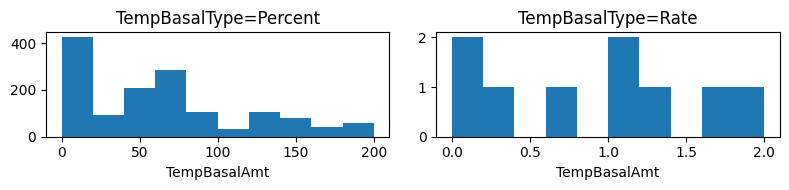

In [15]:
display(df_insulin.loc[df_insulin.TempBasalType =="Percent",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))
display(df_insulin.loc[df_insulin.TempBasalType =="Rate",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))

fig, axs = plt.subplots(1,2, figsize=(8, 2))
axs[0].hist(df_insulin.loc[df_insulin.TempBasalType =="Percent",'TempBasalAmt'])
axs[0].set_title('TempBasalType=Percent'); axs[0].set_xlabel('TempBasalAmt')
axs[1].hist(df_insulin.loc[df_insulin.TempBasalType =="Rate",'TempBasalAmt'])
axs[1].set_title('TempBasalType=Rate'); axs[1].set_xlabel('TempBasalAmt')

plt.tight_layout()

<div class="alert alert-block alert-info">TempBasalAmt contains a percentage value if TempBasalType=='Percent' or a rate U/h if TempBasalType=='Rate'. </div>

<div class="alert alert-block alert-info"> The maximum basal temp basal rate programmed using the "Rate" feature only reached 2U/h. While higher temp basal rates can be programmed, only 9 such event mean that this feature was only used by a few users.</div>

<div class="alert alert-block alert-warning">
<b>Interpreting Temp Basal of 100 Percent:</b> The manual notices that *The percentage used is based on the largest basal rate scheduled during the temp basal rate duration*, a value of 100 still changes the basl rate to the highest standard basal rate that would occur within the duration of the temp basal rate. 
</div>

### Are temp basal rates reflected in the BasalRt?
The TempBasalAmt tells us how much the standard rate is changed. It is unclear weather these changes are already reflected in the BasalRt. Do figure this out we can check what happens to BasalRt when somebody uses a fixed basal rate or 0%.

No handles with labels found to put in legend.


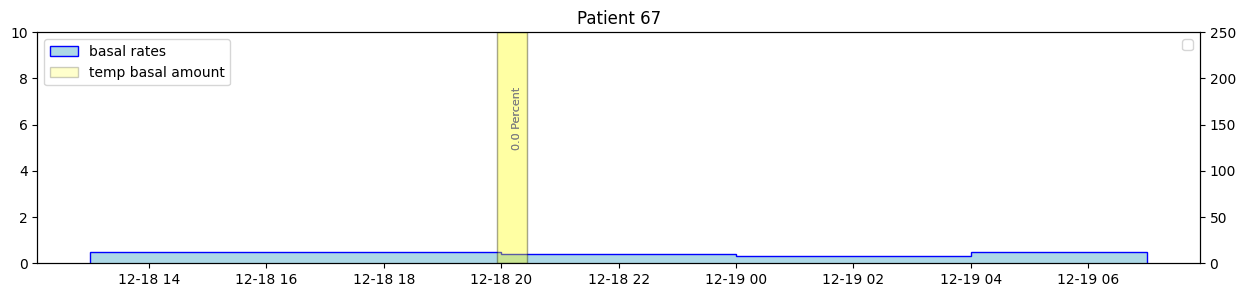

In [16]:
def parse_duration(duration_str):
  """
  Parses a duration string in format "HH:MM:SS" to timedelta.

  Args:
      duration_str: The duration string to parse.

  Returns:
      A timedelta object representing the parsed duration.
  """
  hours, minutes, seconds = map(int, duration_str.split(":"))
  return timedelta(hours=hours, minutes=minutes, seconds=seconds)

def drawBasal(ax, datetimes, rates, color='lightblue'):
    ax.stairs(rates[:-1],datetimes, label='basal rates',color=color,fill=True,alpha=1,edgecolor='blue')

def drawInsulinEvents(df, b_draw_boluses=True, b_draw_basal=True, b_draw_temp_basal=True):
    f = plt.figure(figsize=(15,3))
    ax = f.gca();
    twinax=ax.twinx()
    plt.title(f"Patient {df.PtID.iloc[0]}")

    temp = df.copy()
    temp = temp.sort_values("DateTime")
    boluses = temp.dropna(subset=['BolusDeliv'],axis=0)
    basalRates = temp.dropna(subset=['BasalRt'],axis=0)
    tmpBasals = temp.dropna(subset=['TempBasalAmt'],axis=0)

    #boluses
    if (len(boluses) > 0) & b_draw_boluses:
        ax.bar(boluses.DateTime, boluses.BolusDeliv, width=timedelta(minutes=15), label='boluses')
        
    #basal rates
    if (len(basalRates) > 0) & b_draw_basal:
        drawBasal(ax,basalRates.DateTime,basalRates.BasalRt)
    
    if (len(tmpBasals) > 0) & b_draw_temp_basal:    
        colors = tmpBasals.apply(lambda x: 'yellow' if x.TempBasalType == 'Percent' else 'orange',axis=1)
        heights = tmpBasals.apply(lambda x: x.TempBasalAmt if  x.TempBasalType == 'Rate' else 2,axis=1)
        widths = tmpBasals.TempBasalDur.apply(parse_duration)
        ax.bar(tmpBasals.DateTime, 10, color=colors, width=widths, align='edge', label='temp basal amount', alpha=0.2, edgecolor='black')
        # add the temp basal amount as text above the bars
        for i, row in tmpBasals.iterrows():
            ax.text(row.DateTime+parse_duration(row.TempBasalDur)/2, 5, f"{row.TempBasalAmt} {row.TempBasalType}", fontsize=8,color='gray',rotation=90)
        
    
    ax.set_ylim([0,10]);
    ax.legend(loc='upper left')
    twinax.set_ylim([0,250])
    twinax.legend(loc="upper right")
    return ax

def selectRegionAroundEvent(df, patient_id, date_time, hours):
    sub_frame = df.loc[(df.PtID==patient_id) & (df.DateTime>date_time-timedelta(hours=hours)) & (df.DateTime<date_time+timedelta(hours=hours))]
    return sub_frame

random_index = random.choice(df_insulin.loc[(df_insulin.TempBasalAmt==0 ) & (df_insulin.TempBasalType=="Percent")].index)
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 12)
drawInsulinEvents(subFrame, b_draw_boluses=False); 

#### Checking events set to 0 *Percent*
Let's first look at a random temp basal event with temp basal set to zero and plot some data around it

No handles with labels found to put in legend.


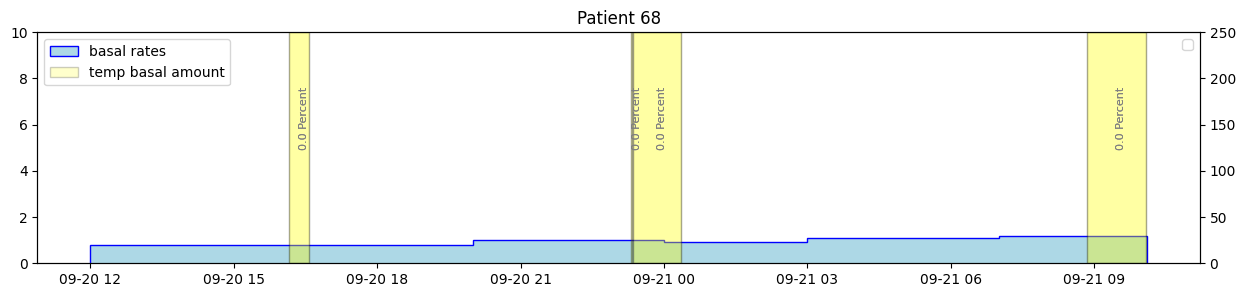

In [17]:
random_index = random.choice(df_insulin.loc[(df_insulin.TempBasalAmt==0 ) & (df_insulin.TempBasalType=="Percent")].index)
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 12)
drawInsulinEvents(subFrame, b_draw_boluses=False); 

Event **963056** shows a situation where the temp basal rate is set to zero (*Percent*). Let's look at this:

No handles with labels found to put in legend.


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
963131,63,9/21/2018 1:13:00 PM,1.10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 13:13:00
963125,63,9/21/2018 2:00:00 PM,1.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 14:00:00
4155915,63,9/21/2018 5:44:07 PM,NaN,False,0.0,Percent,00:30:00,NaN,NaN,NaN,NaN,2018-09-21 17:44:07
963059,63,9/21/2018 5:44:07 PM,NaN,False,0.0,Percent,0:30:00,NaN,NaN,NaN,NaN,2018-09-21 17:44:07
963058,63,9/21/2018 5:45:00 PM,1.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 17:45:00
963057,63,9/21/2018 6:15:00 PM,1.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 18:15:00
4155914,63,9/21/2018 6:30:50 PM,NaN,False,0.0,Percent,00:30:00,NaN,NaN,NaN,NaN,2018-09-21 18:30:50
963056,63,9/21/2018 6:30:50 PM,NaN,False,0.0,Percent,0:30:00,NaN,NaN,NaN,NaN,2018-09-21 18:30:50
963055,63,9/21/2018 6:31:00 PM,1.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 18:31:00
963054,63,9/21/2018 7:01:00 PM,1.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-21 19:01:00


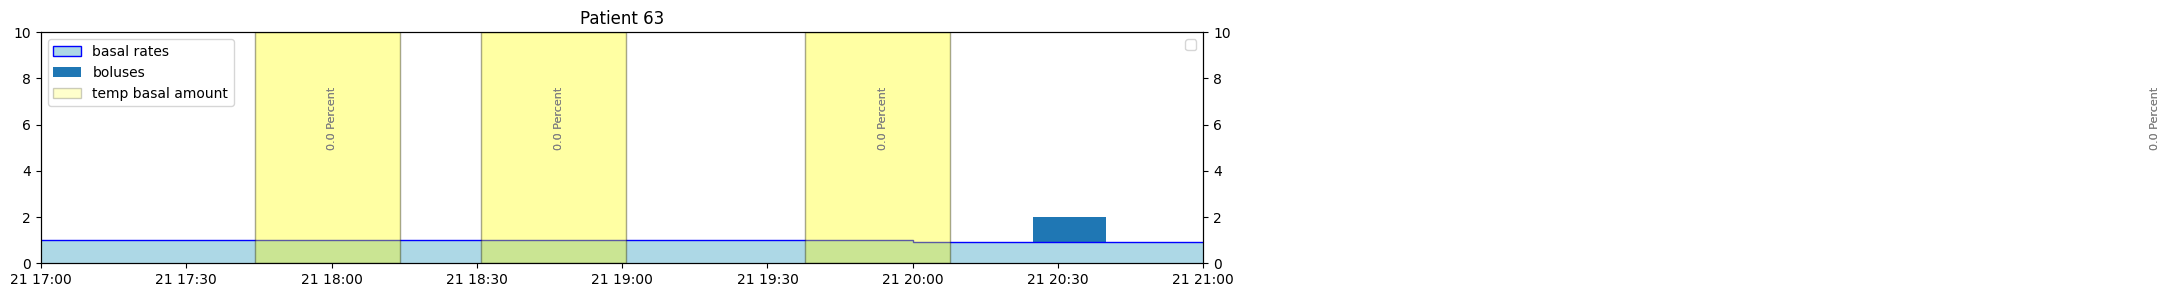

In [18]:
random_index = 963056 
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 5.5)
drawInsulinEvents(subFrame); plt.ylim(0,10); plt.xlim([datetime(2018,9,21,17),datetime(2018,9,21,21)]);
display(subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all').sort_values('DateTime',ascending=True))

**We can see a couple of things here:** 
1. we see that when the temp basal starts and stops, BasalRt events are reported
2. However, the temp basal events are sometimes reported prior, sometimes after the BasalRt events
3. Temp basal events can be reported multiple times (at least in this example), the duration format differs with leading 0 or two leading zeros for the hour
4. During temp basal duration BasalRt events are still being reported

Let's look at another example for row **1044474**. This confirms the past example: 

No handles with labels found to put in legend.


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
1044536,68,9/24/2018 7:00:00 AM,1.2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-24 07:00:00
4383566,68,9/24/2018 8:20:44 AM,NaN,False,0.0,Percent,00:30:00,NaN,NaN,NaN,NaN,2018-09-24 08:20:44
1044526,68,9/24/2018 8:20:44 AM,NaN,False,0.0,Percent,0:30:00,NaN,NaN,NaN,NaN,2018-09-24 08:20:44
1044525,68,9/24/2018 8:21:00 AM,1.2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-24 08:21:00
1044524,68,9/24/2018 8:51:00 AM,1.2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-24 08:51:00
1044523,68,9/24/2018 9:22:04 AM,NaN,False,0.0,Percent,1:00:00,NaN,NaN,NaN,NaN,2018-09-24 09:22:04
4383565,68,9/24/2018 9:22:04 AM,NaN,False,0.0,Percent,01:00:00,NaN,NaN,NaN,NaN,2018-09-24 09:22:04
1044522,68,9/24/2018 9:23:00 AM,1.2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-24 09:23:00
1044521,68,9/24/2018 10:23:00 AM,1.2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-24 10:23:00
1044478,68,9/24/2018 11:51:29 AM,NaN,False,0.0,Percent,0:30:00,NaN,NaN,NaN,NaN,2018-09-24 11:51:29


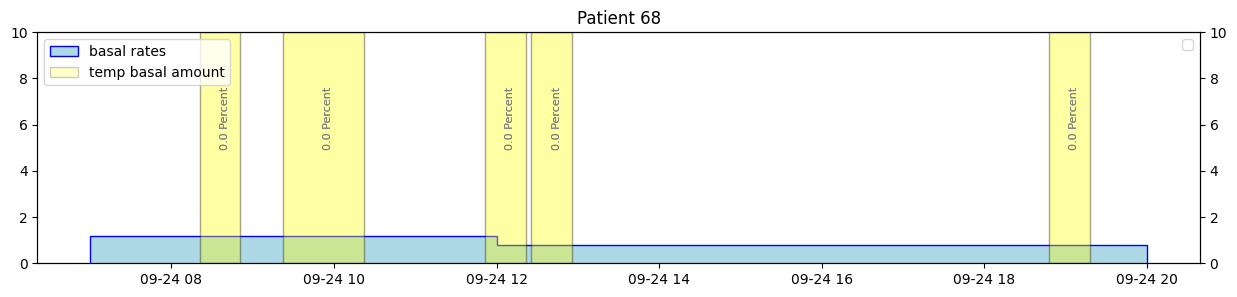

In [19]:
#same just with a fixed event (for reproducibility)
subFrame = selectRegionAroundEvent(df_insulin,  df_insulin.loc[1044474,'PtID'],  df_insulin.loc[1044474,'DateTime'], 8)
drawInsulinEvents(subFrame, b_draw_boluses=False); 
display(subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all').sort_values('DateTime',ascending=True)); plt.ylim(0,10);

#### Events with rate set to >0 Percent
Last check is on one example where the percent is not zero to confirm that reporting is consistent

,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
1077284,37,12/31/2018 7:00:00 AM,2.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 07:00:00
1077277,37,12/31/2018 12:00:00 PM,2.20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 12:00:00
1077270,37,12/31/2018 3:00:00 PM,2.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 15:00:00
1077262,37,12/31/2018 5:34:21 PM,NaN,False,60.0,Percent,2:15:00,NaN,NaN,NaN,NaN,2018-12-31 17:34:21
2312572,37,12/31/2018 5:34:21 PM,NaN,False,60.0,Percent,02:15:00,NaN,NaN,NaN,NaN,2018-12-31 17:34:21
1077261,37,12/31/2018 5:35:00 PM,2.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 17:35:00
1077254,37,12/31/2018 7:50:00 PM,2.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 19:50:00
1077249,37,1/1/2019,1.55,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00


No handles with labels found to put in legend.


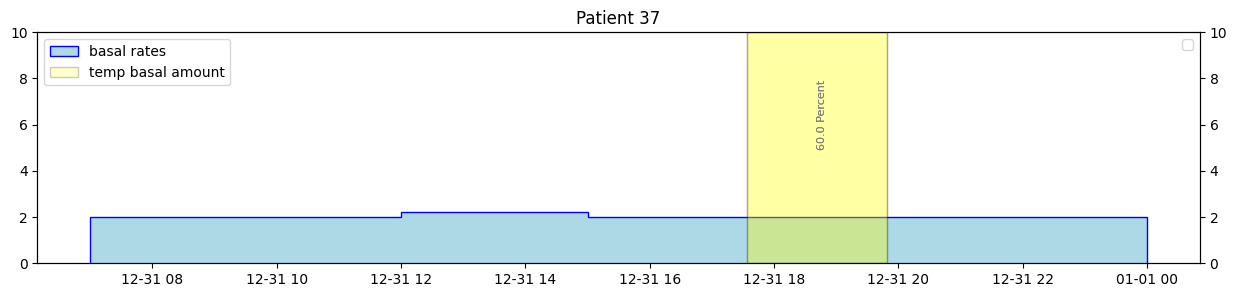

In [20]:
random_index = 2312572
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 12)
display(subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all').sort_values('DateTime',ascending=True))
drawInsulinEvents(subFrame, b_draw_boluses=False); plt.ylim(0,10);

Yes, it looks consistent

### Looking at Temporary Basal *Rate* Type
Let's check if there is a difference in reporting, when the temporary basal rate is at a fixed rate.

In [21]:
#let's check how many of these events we actually have:
fixedRateTempBasalRateEvents = df_insulin.loc[df_insulin.TempBasalType=="Rate"]
print(f"There are only {fixedRateTempBasalRateEvents.shape[0]} temp basal events with a fixed rate.")
display(fixedRateTempBasalRateEvents)

There are only 9 temp basal events with a fixed rate.


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
58519,15,6/24/2019 11:47:55 AM,NaN,False,0.10,Rate,0:01:00,NaN,NaN,NaN,NaN,2019-06-24 11:47:55
498999,116,5/17/2019 8:04:58 AM,NaN,False,1.60,Rate,0:49:00,NaN,NaN,NaN,NaN,2019-05-17 08:04:58
500045,116,5/6/2019 11:44:36 AM,NaN,False,1.30,Rate,1:30:00,NaN,NaN,NaN,NaN,2019-05-06 11:44:36
500214,116,5/4/2019 9:16:36 PM,NaN,False,1.00,Rate,1:00:00,NaN,NaN,NaN,NaN,2019-05-04 21:16:36
500876,116,4/24/2019 8:01:41 PM,NaN,False,1.10,Rate,1:30:00,NaN,NaN,NaN,NaN,2019-04-24 20:01:41
688128,29,3/30/2019 2:39:40 PM,NaN,False,0.00,Rate,0:17:00,NaN,NaN,NaN,NaN,2019-03-30 14:39:40
824691,96,4/7/2019 5:30:44 PM,NaN,False,2.00,Rate,0:45:00,NaN,NaN,NaN,NaN,2019-04-07 17:30:44
1633279,116,8/24/2019 3:41:29 PM,NaN,False,0.70,Rate,2:30:00,NaN,NaN,NaN,NaN,2019-08-24 15:41:29
2320200,15,12/15/2019 12:33:05 AM,NaN,False,0.38,Rate,2:30:00,NaN,NaN,NaN,NaN,2019-12-15 00:33:05


No handles with labels found to put in legend.


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime
824916,96,4/7/2019 8:00:00 AM,1.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 08:00:00
824850,96,4/7/2019 9:38:48 AM,NaN,False,130.0,Percent,0:26:00,NaN,NaN,NaN,NaN,2019-04-07 09:38:48
824849,96,4/7/2019 9:39:00 AM,1.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 09:39:00
824843,96,4/7/2019 10:00:00 AM,1.4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 10:00:00
824842,96,4/7/2019 10:05:00 AM,1.4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 10:05:00
824706,96,4/7/2019 4:00:00 PM,1.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 16:00:00
824705,96,4/7/2019 4:31:37 PM,NaN,False,135.0,Percent,0:45:00,NaN,NaN,NaN,NaN,2019-04-07 16:31:37
824704,96,4/7/2019 4:32:00 PM,1.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 16:32:00
824692,96,4/7/2019 5:17:00 PM,1.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-07 17:17:00
824691,96,4/7/2019 5:30:44 PM,NaN,False,2.0,Rate,0:45:00,NaN,NaN,NaN,NaN,2019-04-07 17:30:44


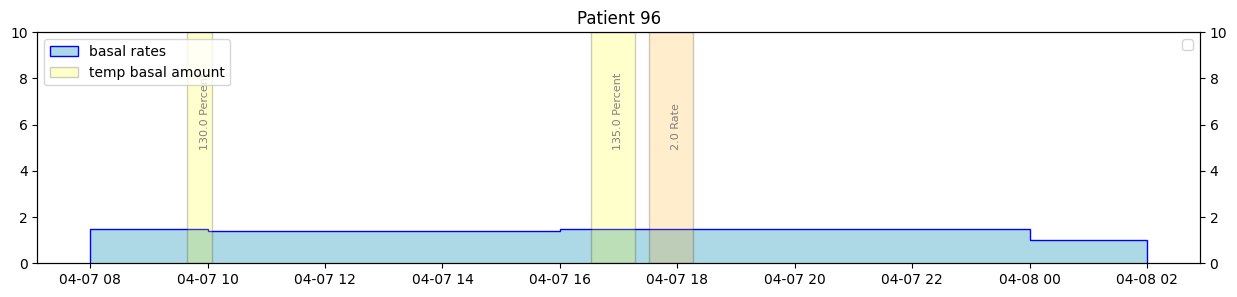

In [22]:
#we select a random temp basal event with temp basal set to zero and some data around it
random_index = 824691
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 12)
drawInsulinEvents(subFrame, b_draw_boluses=False);
display(subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all').sort_values('DateTime',ascending=True)); plt.ylim(0,10);

We can see, that in these cases, the reporting is slightly different. Temp basal rate is  
* **Not reported twice** 
 * basalrate is **not** reported shortly after!

## What we learned about basal rates
* Standard basal rates do not reflect temporary basal rate changes
* Temporary basal rates are either given as Percent (of the normal basal) or as Rate (replacing standard basal)
* During temp basal rates are active, Standard BasalRt events can change and are reported

### Percent
* Standard Basal rates are reported shortly after temp basal start and stop
* Temporary Basal Percent rates are reported **twice**, with the same timestamp but the duration format differs with leading 0 or without leading zeros for the hour (e.g. 00:15:00) vs.(0:15:00) 

### Rate
* There are only 9 cases where temporary basal is "Rate", in these cases, standard basal rate is not reported shortly after the temp basal rate *starts*
3. Temporary Basal Percent rates are reported **once**, without leading 0 for duration hour (0:15:00) 

### Takeaway:
To reconstruct true basal rates, we need to consider the TempBasalAmt and TempBasalType. We can use the BasalRt events as a basis and apply the TempBasalAmt for the duration of the TempBasalDur. Depending on the value of the TempBasalType, we either need to multiply the BasalRt by the TempBasalAmt (when TempBasalType is "Percent") or we can directly set the BasalRt to the TempBasalAmt (when TempBasalType is "rate"). 

To create the correct event history, we take advantage of the fact that basal rates are reported shortly after a Percent rate is set. Here, we simply multiply all basal rates within the temp basal duration period. After the temp basal duration, the standard basal rate is reported and automatically takes over. In the "Rate" case, we know that the standard basal rate is not reported shortly after the temp basal starts, so we need to treat the event as a new basal rate by copying the temp basal amount. While the temp basal Rate is set, standard basal rate changes should be ignored, we do this by setting all basal rates within the active duration to NaN (not 0!). As before, we take advantage of the fact that after the temp basal stops, a standard basal event is reported and automtaically takes over. 
    
<div class="alert alert-block alert-warning">
<b>Temp Basal Not Reflected in Basal Rate:</b> As we can see, the temporary Basal Events do not affect the basal rate. Therefore, we need to do post-processing to obtain the real basal rate
</div>

## Reconstructing True Basal Rates

In [23]:
import numpy as np
from datetime import timedelta
def calculate_absolute_basal(df):
    absolute_basal = df.BasalRt.copy().rename('AbsoluteBasal') #start with the Standard Basal Rates
    df_sub_temp_basals = df.loc[df.TempBasalAmt.notna()]
    df_sub_basals = df.loc[df.BasalRt.notna()]

    for index, row in df_sub_temp_basals.iterrows():
        #get basal events within temp basal active duration
        temp_basal_interval = pd.Interval(row.DateTime, row.DateTime + convert_duration_to_timedelta(row.TempBasalDur))
        affected_basal_indexes = df_sub_basals.index[df_sub_basals.DateTime.apply(lambda x: x in temp_basal_interval)]
        
        #multiply if Percent
        if row.TempBasalType == 'Percent':
            absolute_basal.loc[affected_basal_indexes] = df_sub_basals.BasalRt.loc[affected_basal_indexes]*row.TempBasalAmt/100
        #replace if Rate (set to NaN if Rate is set)
        else:
            absolute_basal.loc[index] = row.TempBasalAmt
            absolute_basal[affected_basal_indexes] = np.NaN
    return absolute_basal

def convert_duration_to_timedelta(duration):
    hours, minutes, seconds = map(int, duration.split(':'))
    return timedelta(hours=hours, minutes=minutes, seconds=seconds)

def drawAbsoluteBasalRates(datetimes, rate, ax):
    i_sorted = np.argsort(datetimes)
    ax.stairs(rate[i_sorted][:-1], datetimes[i_sorted],  hatch='//', label='true basal rate', edgecolor='black')


No handles with labels found to put in legend.


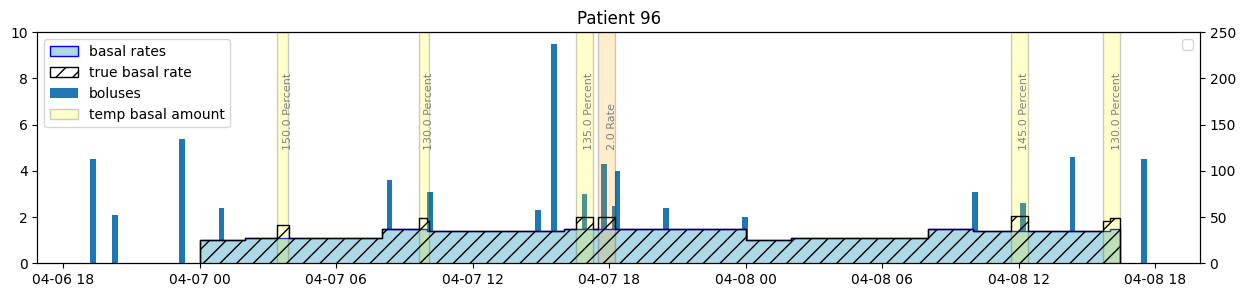

In [24]:
random_index = 824691
hours = 24

subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], 
                                   df_insulin.loc[random_index,'DateTime'], 24).copy()
subFrame = subFrame.sort_values('DateTime')
subFrame['AbsoluteBasal'] = calculate_absolute_basal(subFrame)

ax = drawInsulinEvents(subFrame)
drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values,
                                           subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values,ax)
ax.legend()

## For the whole dataset

In [25]:
absolute_basal = df_insulin.groupby('PtID').apply(calculate_absolute_basal)
absolute_basal = absolute_basal.reset_index(level=0,drop=True)
df_insulin['AbsoluteBasal'] = df_insulin.index.map(absolute_basal)

No handles with labels found to put in legend.


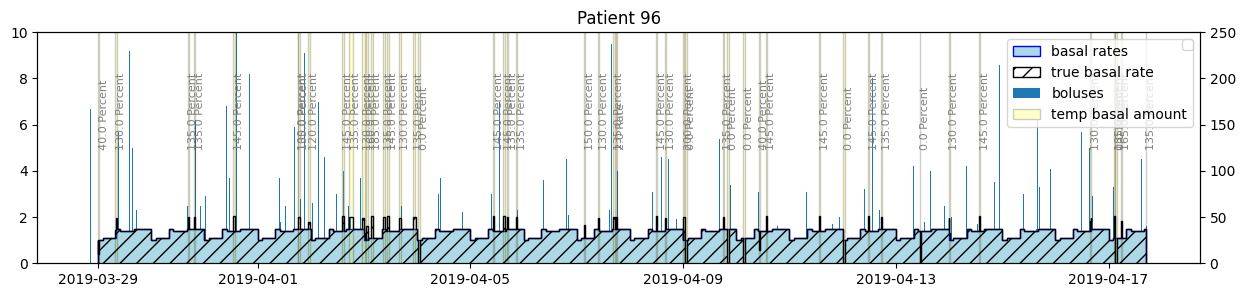

In [75]:
random_index = 824691
hours = 24

subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 10*24).copy()
subFrame = subFrame.sort_values('DateTime')

ax = drawInsulinEvents(subFrame)
drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values,
                       subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values,ax)
ax.legend()

In [ ]:
## Indexing Problems

In [ ]:
print(random_sample.DateTime.values[0])
print(type(random_sample.DateTime.values[0]))
print(df_insulin.loc[random_index,'DateTime'])
print(type(df_insulin.loc[random_index,'DateTime']))
#this is why one call fails while the other works, they return different types

#probably because
random_index = df_insulin.loc[df_insulin.TempBasalAmt.notna()].sample().index.values[0]
#is not the same as
random_index = df_insulin.loc[df_insulin.TempBasalAmt.notna()].sample().index

## Suspend Events

No handles with labels found to put in legend.


2018-08-31 00:00:00 2019-05-11 11:31:44


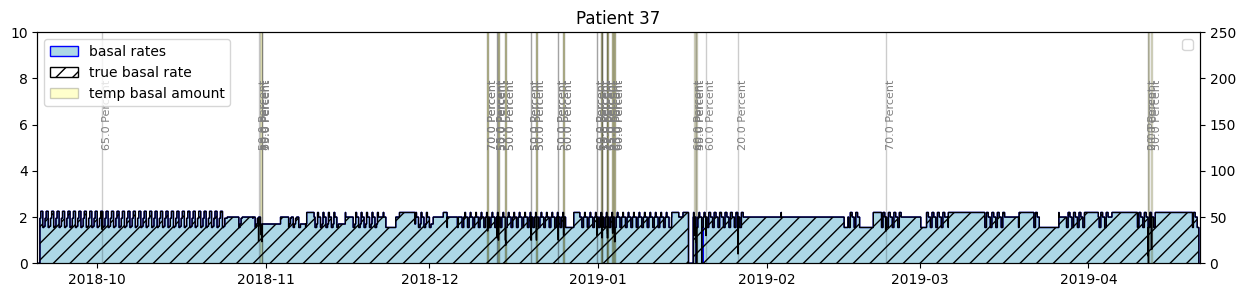

In [138]:
#get a user with>10 Suspend and Temporary Basal events
event_counts = df_insulin.groupby('PtID').agg({"Suspend":'count','TempBasalAmt':'count'})
users_with_temp_and_suspends = event_counts.loc[(event_counts.Suspend>10) & (event_counts.TempBasalAmt>10)]
random_user = random.choice(users_with_temp_and_suspends.index)

subFrame = df_insulin.loc[df_insulin.PtID==random_user].copy()
subFrame = subFrame.sort_values('DateTime')

ax = drawInsulinEvents(subFrame, b_draw_boluses=False)
drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values,
                       subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values,ax)
ax.legend()
ax.set_xlim(subFrame.DateTime.min(),subFrame.DateTime.max())
print(subFrame.DateTime.min()-timedelta(days=20),subFrame.DateTime.max()+timedelta(days=20))


In [140]:
subFrame.loc[subFrame.Suspend=='Suspend']

,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,Suspend,DateTime,AbsoluteBasal
72953,37,9/20/2018 11:07:33 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,ALARM_SUSPEND,2018-09-20 11:07:33,NaN
72951,37,9/20/2018 11:07:51 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL_PUMPING,2018-09-20 11:07:51,NaN
72944,37,9/20/2018 11:42:58 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NOTSEATED_SUSPEND,2018-09-20 11:42:58,NaN
72940,37,9/20/2018 11:44:08 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL_PUMPING,2018-09-20 11:44:08,NaN
72892,37,9/21/2018 7:44:54 PM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,USER_SUSPEND,2018-09-21 19:44:54,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2315951,37,4/19/2019 9:56:26 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL_PUMPING,2019-04-19 09:56:26,NaN
2315949,37,4/19/2019 10:06:58 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NOTSEATED_SUSPEND,2019-04-19 10:06:58,NaN
2315945,37,4/19/2019 10:10:23 AM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL_PUMPING,2019-04-19 10:10:23,NaN
2315185,37,4/19/2019 11:31:32 PM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,ALARM_SUSPEND,2019-04-19 23:31:32,NaN


In [149]:
counts = df_insulin.Suspend.value_counts()
display(counts)
print(f"There are {counts['NORMAL_PUMPING']} NORMAL_PUMPING events and {counts.drop('NORMAL_PUMPING').sum()} other Suspend events.")

NORMAL_PUMPING                 36217
USER_SUSPEND                   14890
NOTSEATED_SUSPEND               9340
SmartGuard_PREDICTED_LOW_SG     5306
ALARM_SUSPEND                   4618
PLGM_PREDICTED_LOW_SG           1297
LOWSG_SUSPEND                    751
AUTO_SUSPEND                       5
Name: Suspend, dtype: int64

There are 36217 NORMAL_PUMPING events and 36207 other Suspend events.


The very small difference is likely due to glucose suspend events that were started before the observation period. But this makes matching a little **more difficult**. We want to make sure we match the right pairs!


In [150]:
#we can get the pairs by grouping by user, then taking all the Suspend values which are NORMAL_PUMPING event DateTimes as end times and all other Suspend events as start times
df_suspend = df_insulin.loc[df_insulin.Suspend.notna()]
starts = df_suspend.groupby('PtID').apply(lambda x: x.loc[x.Suspend=='NORMAL_PUMPING','DateTime'].values)
ends = df_suspend.groupby('PtID').apply(lambda x: x.loc[x.Suspend!='NORMAL_PUMPING','DateTime'].values)
#group as tuples


PtID
1      [2018-09-11T11:35:24.000000000, 2018-09-11T09:...
2      [2018-12-18T21:59:27.000000000, 2018-12-18T01:...
3      [2019-01-06T22:51:20.000000000, 2019-01-05T21:...
4      [2019-09-10T22:27:41.000000000, 2019-09-10T14:...
5      [2019-06-23T15:58:20.000000000, 2019-06-22T13:...
                             ...                        
122    [2019-08-26T06:38:54.000000000, 2019-08-25T22:...
123    [2019-08-15T02:49:59.000000000, 2019-08-15T02:...
124    [2019-07-14T15:28:08.000000000, 2019-07-14T14:...
125    [2019-05-15T09:54:51.000000000, 2019-05-15T06:...
126    [2018-12-07T16:46:26.000000000, 2018-12-04T21:...
Length: 115, dtype: object

In [153]:
df_suspend.groupby('PtID').apply(lambda x: x.loc[x.Suspend=='NORMAL_PUMPING','DateTime'].values).explode().rename('starts')


PtID
1     2018-09-11 11:35:24
1     2018-09-11 09:32:17
1     2018-09-10 20:43:38
1     2018-09-09 08:25:24
1     2018-09-07 15:08:20
              ...        
126   2019-03-24 00:39:45
126   2019-03-21 01:23:14
126   2019-03-20 11:15:31
126   2019-03-19 11:45:09
126   2019-03-18 11:07:44
Name: starts, Length: 36217, dtype: datetime64[ns]

In [174]:
subFrame=df_insulin.loc[df_insulin.PtID==random_user & df_insulin.Suspend.notna()].copy()
subFrame = subFrame.sort_values('DateTime')
subFrame['PreviousSuspend'] = subFrame.Suspend.shift(1)
subFrame['DateTimePreviousSuspend'] = subFrame.DateTime.shift(1)
sessions = subFrame.loc[(subFrame.PreviousSuspend!='NORMAL_PUMPING') & (subFrame.Suspend=='NORMAL_PUMPING')]
sessions['Duration'] = sessions.DateTime-sessions.DateTimePreviousSuspend
sessions[['PreviousSuspend','DateTimePreviousSuspend','Suspend','DateTime','Duration']]
sessions.Duration.describe()

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_22710/1355309425.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions['Duration'] = sessions.DateTime-sessions.DateTimePreviousSuspend


count                          186
mean     0 days 00:38:53.311827956
std      0 days 00:47:27.004963887
min                0 days 00:00:03
25%         0 days 00:01:55.750000
50%         0 days 00:08:29.500000
75%                0 days 01:08:56
max                0 days 03:24:19
Name: Duration, dtype: object